In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile
from PIL import Image

# SimPEG functionality
from simpeg.potential_fields import gravity
from simpeg.utils import plot2Ddata, model_builder
from simpeg import maps

# discretize functionality
from discretize import TensorMesh, TreeMesh
from discretize.utils import mkvc, active_from_xyz

# Common Python functionality
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
from scipy.interpolate import griddata

from simpeg import (
    data,
    data_misfit,
    directives,
    inverse_problem,
    inversion,
    maps,
    optimization,
    regularization,
    utils,
)

# Now you can use griddata in your code.

mpl.rcParams.update({"font.size": 14})
import matplotlib.pyplot as plt

save_output = False  # Optional
from scipy.interpolate import interp1d, CubicSpline
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import griddata


### Import data set

In [2]:
file_path = "AllBouguerAnomalies_2021Corrected_2022.xlsx"
df = pd.read_excel(file_path, names = ["station", "lat", "lon", "z", "E", "N", "g_abs", "g_corrected",
                                      "elips_g", "fae", "free_air_anomaly", "bouguer_slab", "terrain_faa", "proper_ba","a"])
df

,station,lat,lon,z,E,N,g_abs,g_corrected,elips_g,fae,free_air_anomaly,bouguer_slab,terrain_faa,proper_ba,a
0,C001,49.969703,-123.166620,438.378,488051.4,5535275.5,980842.078,980844.295,981067.653956,-135.283451,-88.075505,-49.042662,10.095541,-77.979964,-127.022626
1,C002,49.971766,-123.177925,620.131,487241.2,5535506.7,980812.173,980814.390,981067.837987,-191.372427,-62.075560,-69.375915,7.062239,-55.013321,-124.389236
2,C003,49.978179,-123.164255,453.277,488223.0,5536217.5,980841.543,980843.760,981068.410150,-139.881282,-84.768868,-50.709458,8.551281,-76.217586,-126.927044
3,C004,49.986146,-123.158343,403.925,488648.7,5537102.4,980851.044,980853.261,981069.120949,-124.651255,-91.208694,-45.188302,9.570324,-81.638370,-126.826671
4,C005,49.978165,-123.186126,664.181,486654.9,5536219.5,980803.461,980805.678,981068.408866,-204.966257,-57.764609,-74.303921,7.777331,-49.987278,-124.291199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,C138,50.106852,-123.276222,1789.303,480247.9,5550547.6,980583.479,980583.479,981079.885441,-552.178906,55.772465,-200.174695,25.057526,80.829991,-119.344703
142,C139,50.047224,-123.285839,1638.384,479534.9,5543920.4,980617.473,980617.473,981074.568829,-505.605302,48.509473,-183.290933,19.774732,68.284205,-115.006728
143,C140,50.044038,-123.255415,1861.171,481711.9,5543558.4,980575.914,980575.914,981074.284759,-574.357371,75.986612,-208.214783,15.801213,91.787825,-116.426958
144,C141,50.072480,-123.212646,1586.419,484783.2,5546711.1,980632.620,980632.620,981076.821016,-489.568903,45.367888,-177.477453,21.034630,66.402518,-111.074935


### Create a meshgrid

Max: -254.11270418998785


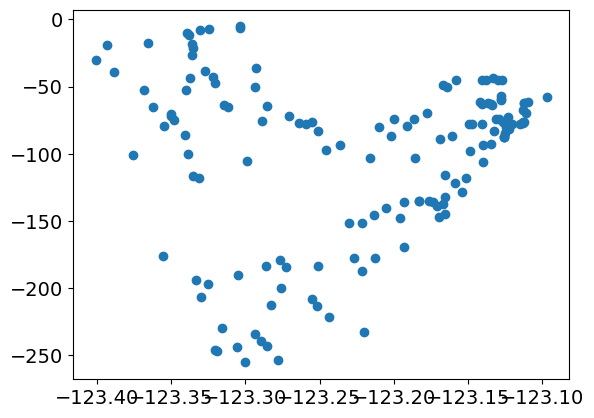

In [3]:
# Extract the values for longitude, latitude, z, and bouguerected
lon = df['lon'].values
lat = df['lat'].values
z = df['z'].values
bouguer = df['bouguer_slab'].values

# Create a regular grid for interpolation based on the range of lon and lat
num_points = 100
lon_lin = np.linspace(lon.min(), lon.max(), num_points)
lat_lin = np.linspace(lat.min(), lat.max(), num_points)
grid_lon, grid_lat = np.meshgrid(lon_lin, lat_lin)

# Interpolate z and bouguerected onto the regular grid using cubic interpolation
grid_z = griddata((lon, lat), z, (grid_lon, grid_lat), method='cubic')
# Interpolate with linear first
grid_bouguer = griddata((lon, lat), bouguer, (grid_lon, grid_lat), method='linear')

# # Fill NaNs using nearest
# nan_mask_z = np.isnan(grid_z)
# nan_mask_b = np.isnan(grid_bouguer)

# grid_z[nan_mask_z] = griddata((lon, lat), z, (grid_lon, grid_lat), method='nearest')[nan_mask]
# grid_bouguer[nan_mask_b] = griddata((lon, lat), bouguer, (grid_lon, grid_lat), method='nearest')[nan_mask]


print("Max:", np.nanmin(grid_bouguer))
plt.scatter(lon, bouguer)

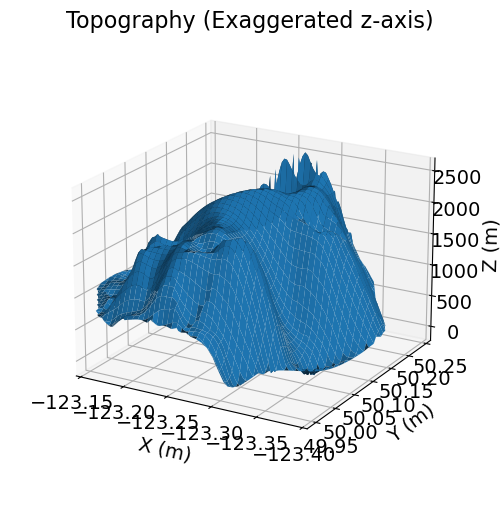

In [4]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection="3d")
# ax.set_zlim([z.max() - 40, z.max()])
ax.set_xlim(-123.15, -123.40)
ax.plot_surface(grid_lon, grid_lat, grid_z) #,  linewidth=0.5)
ax.set_box_aspect(aspect=None, zoom=0.85)
ax.set_xlabel("X (m)", labelpad=10)
ax.set_ylabel("Y (m)", labelpad=10)
ax.set_zlabel("Z (m)", labelpad=10)
ax.set_title("Topography (Exaggerated z-axis)", fontsize=16, pad=-20)
ax.view_init(elev=20.0)

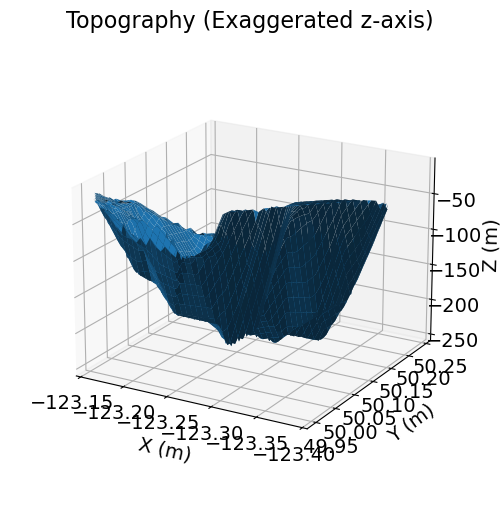

In [5]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection="3d")
# ax.set_zlim([z.max() - 40, z.max()])
ax.set_xlim(-123.15, -123.40)
ax.plot_surface(grid_lon, grid_lat, grid_bouguer,  linewidth=0.5)
ax.set_box_aspect(aspect=None, zoom=0.85)
ax.set_xlabel("X (m)", labelpad=10)
ax.set_ylabel("Y (m)", labelpad=10)
ax.set_zlabel("Z (m)", labelpad=10)
ax.set_title("Topography (Exaggerated z-axis)", fontsize=16, pad=-20)
ax.view_init(elev=20.0)

### plot imported data

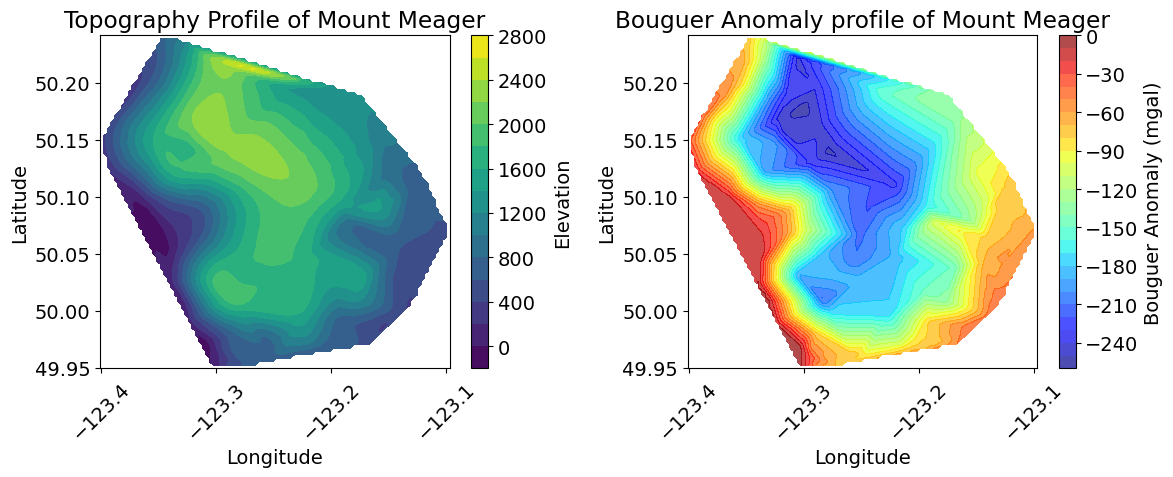

Min: -254.11270418998785
Max: -5.5847306683322


In [6]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))

ctr1 = ax[0].contourf(grid_lon, grid_lat, grid_z, cmap='viridis', levels=15)
ax[0].set_title("Topography Profile of Mount Meager")
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel("Latitude")
ax[0].tick_params(axis='x', labelrotation=45)
fig.colorbar(ctr1, ax=ax[0], label="Elevation")

ctr2 = ax[1].contourf(grid_lon, grid_lat, grid_bouguer, cmap='jet',alpha=0.7, levels=30)
ax[1].set_title("Bouguer Anomaly profile of Mount Meager")
ax[1].set_xlabel("Longitude")
ax[1].set_ylabel("Latitude")

ax[1].tick_params(axis='x', labelrotation=45)
fig.colorbar(ctr2, ax=ax[1], label="Bouguer Anomaly (mgal)")

plt.tight_layout()
plt.savefig("figure1")

plt.show()

print("Min:", np.nanmin(grid_bouguer))
print("Max:", np.nanmax(grid_bouguer))




### Convert all the coordinate system into meter

In [7]:
import numpy as np

lat_degree = 50    # degrees (latitude extent)
lon_degree = 123   # degrees (longitude extent)

earth_radius = 6378e3  # Earth's radius in meters

# Conversion factor for one degree (at the equator) in meters:
m_per_degree = (2 * np.pi * earth_radius) / 360

# Distance for a given latitude difference (nearly constant on a spherical Earth)
lat_distance_m = lat_degree * m_per_degree

# Distance for a given longitude difference at a specific latitude:
lon_distance_m = lon_degree * m_per_degree * np.cos(np.deg2rad(50))

In [8]:
x_median = -123.25
# x_median = -123.2
# x_median = -123.3
x = lon * m_per_degree  * np.cos(np.deg2rad(50)) - x_median * m_per_degree  * np.cos(np.deg2rad(50))
grid_x = grid_lon * m_per_degree  * np.cos(np.deg2rad(50)) - x_median * m_per_degree  * np.cos(np.deg2rad(50))
# grid_x_km = grid_x/1000

y_median = 50.080
# y_median = 50.075
# y_median = 50.15
y = lat * m_per_degree - y_median * m_per_degree
grid_y = grid_lat * m_per_degree - y_median * m_per_degree
# grid_y_km = grid_y/1000

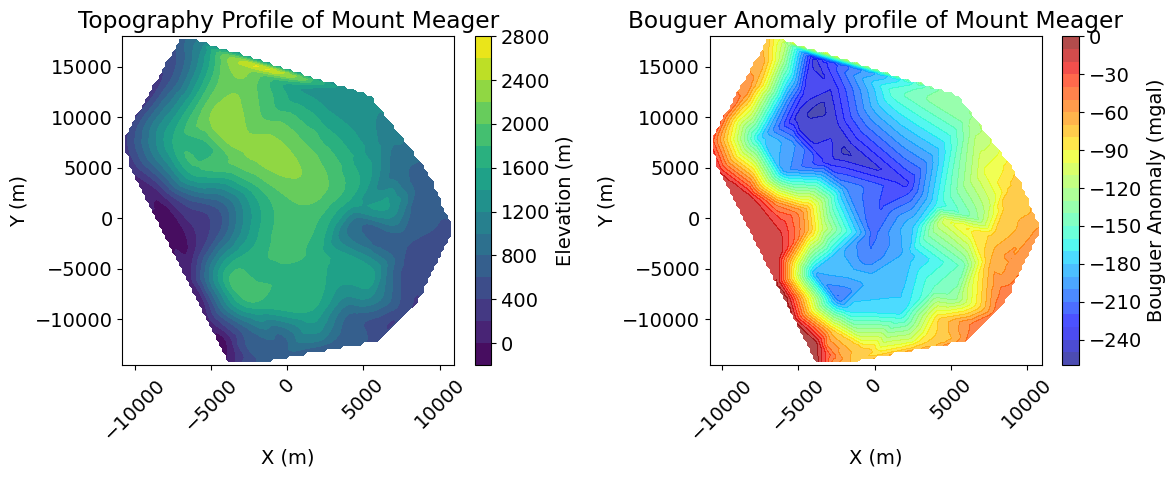

Min: -254.11270418998785
Max: -5.5847306683322


In [9]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))

ctr1 = ax[0].contourf(grid_x, grid_y, grid_z, cmap='viridis', levels=15)
ax[0].set_title("Topography Profile of Mount Meager")
ax[0].set_xlabel("X (m)")
ax[0].set_ylabel("Y (m)")
ax[0].tick_params(axis='x', labelrotation=45)
fig.colorbar(ctr1, ax=ax[0], label="Elevation (m)")

ctr2 = ax[1].contourf(grid_x, grid_y, grid_bouguer, cmap='jet',alpha=0.7, levels=30)
ax[1].set_title("Bouguer Anomaly profile of Mount Meager")
ax[1].set_xlabel("X (m)")
ax[1].set_ylabel("Y (m)")

ax[1].tick_params(axis='x', labelrotation=45)
fig.colorbar(ctr2, ax=ax[1], label="Bouguer Anomaly (mgal)")

plt.tight_layout()
plt.savefig("figure1")


plt.show()


print("Min:", np.nanmin(grid_bouguer))
print("Max:", np.nanmax(grid_bouguer))



#### Forward Simulation (2D)

In [10]:
# Gravitational constant in m^3 kg^-1 s^-2
G = 6.67430e-11

# Topographic material density in kg/m^3 (converted from g/cm^3 to kg/m^3)
density = 2.70 * 1000  # 2.67 g/cm³ = 2670 kg/m³
rho = density

# Extract the elevation data from the dataset
elevation = df['z'].values  # Elevation in meters

# Calculate the topographic gravity anomaly (in mGal), using the formula
# Convert gravitational constant to mGal by multiplying by 10^5
# g_topography = -2 * np.pi * G * density * elevation * 1e5  # Multiply by 1e5 to convert to mGal
g_topography = -2 * np.pi * G * rho * elevation * 1e5

# Add the topographic anomaly to the dataset
df['topographic_anomaly'] = g_topography

# Display the first few rows of the dataset with the calculated topographic anomaly
# df[['z', 'topographic_anomaly']].head()
df["Predicted_Bouguer"] = g_topography

# g_topography

Calculate$$ \delta g_{bouguer} $$

In [11]:
g_obs = df["a"]
g_freeair = df["free_air_anomaly"]
g_pred = g_topography

g_pred

plt.figure()


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

### Define Topography

In [12]:
# I used the location of the grid data to design the survey.
x = lon * m_per_degree  * np.cos(np.deg2rad(50)) - x_median * m_per_degree  * np.cos(np.deg2rad(50))
y = lat * m_per_degree - y_median * m_per_degree


# Gravity data
x_topo, y_topo, z_topo = mkvc(x), mkvc(y), mkvc(z)
x_g, y_g, z_g = mkvc(x), mkvc(y), mkvc(bouguer)

topo_xyz = np.c_[x_topo, y_topo, z_topo]
bouguer_xyz = np.c_[x_g, y_g, z_g ]

### Define Survey

In [13]:
# Flatten the grid into coordinate pairs
flat_x = grid_x.flatten()
flat_y = grid_y.flatten()
flat_z = grid_z.flatten()

# Remove any points with NaNs
valid_mask = np.isfinite(flat_z) & np.isfinite(grid_bouguer.flatten())
receiver_locations = np.c_[flat_x[valid_mask], flat_y[valid_mask], flat_z[valid_mask]]
dobs = grid_bouguer.flatten()[valid_mask] 

### Set up the gravity survey

In [14]:
# Define the receivers. The data consist of vertical gravity anomaly measurements.
# The set of receivers must be defined as a list.
receiver_list = gravity.receivers.Point(receiver_locations, components="gz")
receiver_list = [receiver_list]

# Define the source field
source_field = gravity.sources.SourceField(receiver_list=receiver_list)

# Define the survey
survey = gravity.survey.Survey(source_field)

### Design a tensor mesh

In [15]:
# distance = np.sqrt(np.diff(df["N"])**2 + np.diff(df["E"])**2)

# average_spacing = np.mean(distance)
# # average_spacing
# average_spacing

In [16]:
# Generate tensor mesh with top at z = 0 m
dh = 200 # minimum cell size
hx = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]  # discretization along x
hy = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]  # discretization along y
hz = [(dh, 5, -1.3), (dh, 5)]  # discretization along z
tensor_mesh = TensorMesh([hx, hy, hz], "CCN")

# Shift vertically to top same as maximum topography
tensor_mesh.origin += np.array([0.0, 0.0, np.max(topo_xyz[:, 2])])

# # tensor_mesh.origin += np.r_[0.0, 0.0, topo_xyz[:, -1].max()]

In [17]:
print("# of cells: {}".format(tensor_mesh.n_cells))  # Number of cells
print("# of x-faces: {}".format(tensor_mesh.n_faces_x))  # Number of x-faces
print("Origin: {}".format(tensor_mesh.origin))  # bottom-southewest corner
print("Max cell volume: {}".format(tensor_mesh.cell_volumes.max()))  # Largest cell size
print(tensor_mesh.cell_centers[0:5, :])  # Cell center locations

# of cells: 25000
# of x-faces: 25500
Origin: [-6351.206 -6351.206 -1069.361]
Max cell volume: 409487144.1127263
[[-5979.913 -5979.913  -698.068]
 [-5323.01  -5979.913  -698.068]
 [-4817.7   -5979.913  -698.068]
 [-4429.    -5979.913  -698.068]
 [-4130.    -5979.913  -698.068]]


### Define the active cells

In [18]:
active_tensor_cells = active_from_xyz(tensor_mesh, topo_xyz)

n_tensor_active = int(active_tensor_cells.sum())


### Mapping from the Model to Active Cells

In [19]:
starting_tensor_model =  np.ones(n_tensor_active)
reference_tensor_model = np.zeros_like(starting_tensor_model)

In [20]:
# Map for ignoring inactive cells when plotting
tensor_plotting_map = maps.InjectActiveCells(tensor_mesh, active_tensor_cells, np.nan)

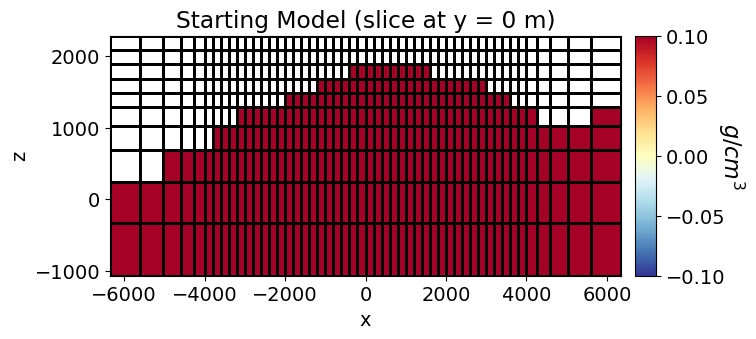

In [21]:
fig = plt.figure(figsize=(7, 3))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

norm = mpl.colors.Normalize(vmin=-0.1, vmax=0.1)
tensor_mesh.plot_slice(
    tensor_plotting_map * starting_tensor_model,
    normal="Y",
    ax=ax1,
    ind=int(tensor_mesh.shape_cells[1] / 2),
    grid=True,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)
ax1.set_title("Starting Model (slice at y = 0 m)")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

plt.savefig("forward_model")
plt.show()

In [22]:
# Indices of the active mesh cells from topography (e.g. cells below surface)
active_cells = active_from_xyz(tensor_mesh, topo_xyz)
np.shape(active_cells)

(25000,)

In [23]:
proper_bouguer = df["a"]

In [24]:
# Define density contrast values for each unit in g/cc
G = 6.67430e-11 
rho = - proper_bouguer / (2 * np.pi * G * z * 1e5)
# rho_mean = np.mean(rho) / 1e5
background_density = rho


# print(np.mean(proper_bouguer), np.mean(bouguer))


Q1 = np.percentile(rho, 25)
Q3 = np.percentile(rho, 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


rho[(rho <= (Q1 - 1.5 * IQR)) & (rho >= (Q3 + 1.5 * IQR))] = np.mean(rho)

# proper_bouguer.shape


In [25]:
# Define mapping from model to active cells. The model consists of a density
# contrast value for each cell below the Earth's surface.
n_active = int(active_cells.sum())
model_map = maps.IdentityMap(nP=n_active)
active_cells

array([ True,  True,  True, ..., False, False, False])

In [26]:
station_xyz = np.c_[x, y, z]  # coordinates of your stations
mesh_xyz = tensor_mesh.cell_centers[active_cells]  # active mesh cell centers

# Interpolate
rho_mapped = griddata(station_xyz, rho, mesh_xyz, method="linear")
rho_mapped[np.isnan(rho_mapped)] = np.mean(rho)  # fill NaNs
# np.shape(rho_mapped)

In [27]:
# active_cells_g = active_from_xyz(tensor_mesh, bouguer_xyz)
# n_active_g = int(active_cells_g.sum())
# np.shape(n_active_g)

In [28]:
model = rho_mapped
print(model)
np.max(model)

[5827.94978744 5827.94978744 5827.94978744 ... 1293.89351624 1290.99589705
 1288.09827785]


27976.733031015185

In [29]:
# Map for ignoring inactive cells when plotting
plotting_map = maps.InjectActiveCells(tensor_mesh, active_cells, np.nan)


/var/folders/xx/z13_9gks5jj49hvr6ptgdslr0000gn/T/ipykernel_77495/4159906178.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


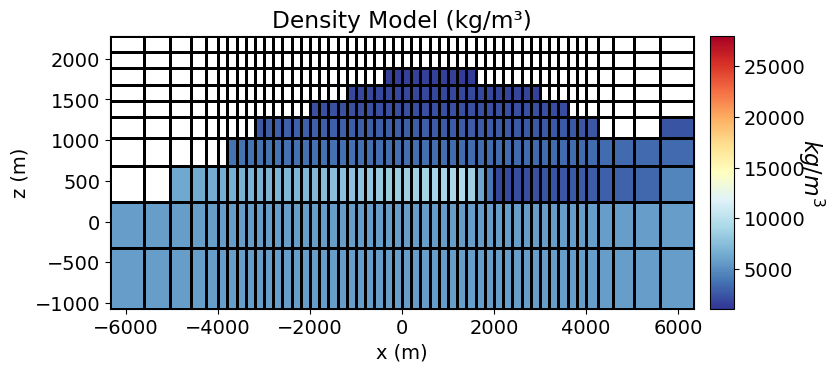

In [30]:
# Plot Density Contrast Model
fig = plt.figure(figsize=(8, 3.5))

ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
tensor_mesh.plot_slice(
    plotting_map * model,
    normal="Y",
    ax=ax1,
    ind=int(tensor_mesh.shape_cells[1] / 2),
    grid=True,
    clim=(np.min(model), np.max(model)),
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r},
)
ax1.set_title("Density Model (kg/m³)")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.85, 0.12, 0.03, 0.78])
norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))

cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)



cbar.set_label("$kg/m^3$", rotation=270, labelpad=15, size=16)

plt.tight_layout()
plt.savefig("density_model")
plt.show()

### Simulate Gravity Anomaly Data

In [31]:
simulation = gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=tensor_mesh,
    rhoMap=model_map,
    active_cells=active_cells,
    store_sensitivities="forward_only",
    engine="choclo",
)

In [32]:
dpred = simulation.dpred(model)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


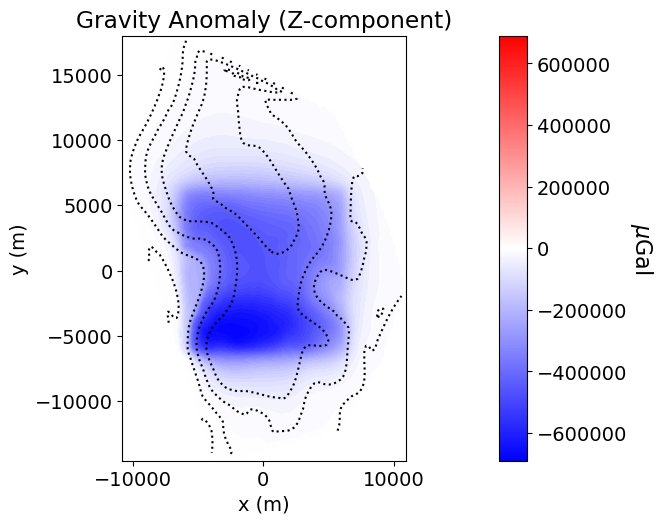

In [33]:
fig = plt.figure(figsize=(7, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])

norm = mpl.colors.Normalize(vmin=-np.max(np.abs(dpred)), vmax=np.max(np.abs(dpred)))
plot2Ddata(
    receiver_list[0].locations,
    dpred,
    ax=ax1,
    ncontour=40,
    contourOpts={"cmap": mpl.cm.bwr, "norm": norm},
)
plt.contour(grid_x, grid_y, grid_z, levels=5, colors='k', linestyles='dotted')
ax1.set_title("Gravity Anomaly (Z-component)")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.81, 0.1, 0.04, 0.85])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr
)
cbar.set_label(r"$\mu$Gal", rotation=270, labelpad=20, size=16)

plt.savefig("gravity_anomaly")
# plt.tight_layout()
plt.show()

### Data Uncertainties

In [34]:
# Define the uncertainty to be ~10mGal
std = 10.0 * np.ones_like(dobs)

### Create the Data Object

In [35]:
data_obj = data.Data(survey, dobs=dobs, standard_deviation=std)

### Define the Data Misfit

In [36]:
dmis = data_misfit.L2DataMisfit(data=data_obj, simulation=simulation)

### Define the Regularization

In [37]:
reg = regularization.WeightedLeastSquares(
    tensor_mesh,
    active_cells=active_tensor_cells,
    length_scale_x=1.0,
    length_scale_y=1.0,
    length_scale_z=1.0,
    reference_model=reference_tensor_model,
    reference_model_in_smooth=False,
)

### Deine the Optimization Algorithm

In [38]:
opt = optimization.InexactGaussNewton(
    maxIter=100, maxIterLS=20, maxIterCG=10, tolCG=1e-2
)

### Define the Inverse Problem

In [39]:
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis, reg, opt)

### Provide Inversion Directives

Directives represent operations that are carried out during the inversion. Here, we apply common directives for weighted least-squares inversion of gravity data and describe their roles. These are:

UpdateSensitivityWeights: Apply sensitivity weighting to counteract the natural tendancy of potential field inversion to cluster recovered structures near the receivers. Because the 3D integral formulation is linear, the sensitivity weighting is independent of the model and does not need to be updated throughout the inversion, so we set every_iteration=False.

UpdatePreconditioner: Apply Jacobi preconditioner when solving optimization problem.

BetaEstimate_ByEig: Compute and set starting trade-off parameter (beta) based on largest eigenvalues.

BetaSchedule: Size reduction of the trade-off parameter at every beta iteration, and the number of Gauss-Newton iterations for each beta.

TargetMisfit: Terminates the inversion when the data misfit equals the target misfit. A chifact=1 terminates the inversion when the data misfit equals the number of data.

In [40]:
sensitivity_weights = directives.UpdateSensitivityWeights(every_iteration=False)
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=10)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=1)
target_misfit = directives.TargetMisfit(chifact=1.0)

directives_list_L2 = [
    sensitivity_weights,
    update_jacobi,
    starting_beta,
    beta_schedule,
    target_misfit,
]

### Define and Run the Inversion

In [41]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run inversion
recovered_tensor_model = inv_L2.run(starting_tensor_model)


Running inversion with SimPEG v0.23.0

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    


/Users/mirei/miniconda3/envs/eosc211/lib/python3.10/site-packages/pymatsolver/wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.67e-06  1.04e+06  3.82e+10  1.10e+06    3.69e+03      0              
   1  8.36e-07  6.39e+05  1.23e+11  7.41e+05    1.07e+03      0              
   2  4.18e-07  5.60e+05  1.89e+11  6.39e+05    6.99e+02      0   Skip BFGS  
   3  2.09e-07  5.01e+05  2.90e+11  5.62e+05    4.52e+02      0   Skip BFGS  
   4  1.04e-07  4.46e+05  4.81e+11  4.96e+05    3.01e+02      0   Skip BFGS  
   5  5.22e-08  3.90e+05  8.68e+11  4.35e+05    2.06e+02      0   Skip BFGS  
   6  2.61e-08  3.38e+05  1.57e+12  3.79e+05    1.41e+02      0   Skip BFGS  
   7  1.31e-08  2.96e+05  2.73e+12  3.31e+05    9.49e+01      0   Skip BFGS  
   8  6.53e-09  2.62e+05  4.56e+12  2.92e+05    8.03e+01      0   Skip BFGS  
   9  3.26e-09  2.31e+05

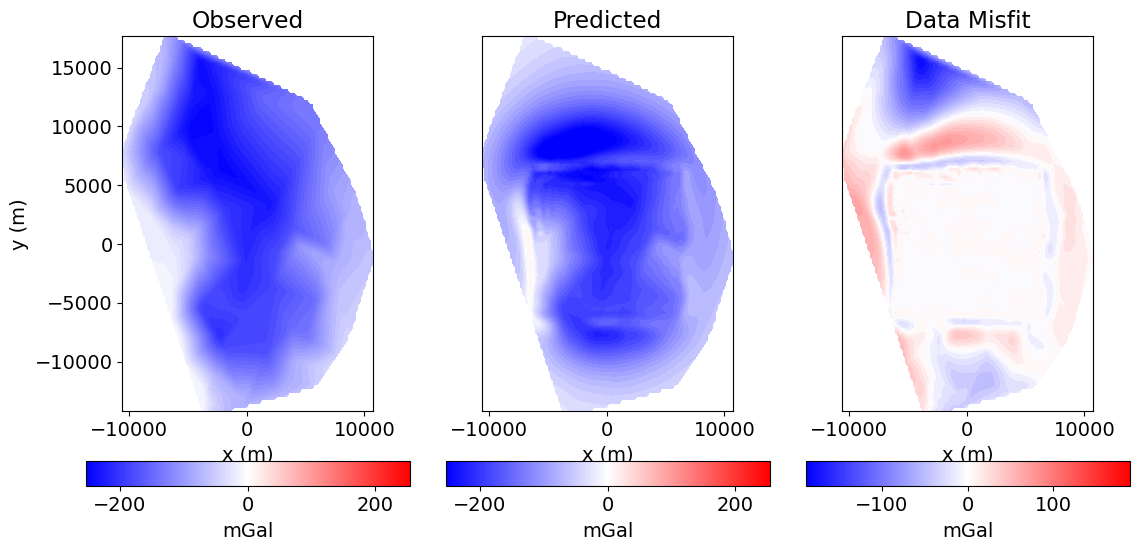

In [42]:
# Predicted data with final recovered model.
dpred = inv_prob_L2.dpred

# Observed data | Predicted data | Data misfit
data_array = np.c_[dobs, dpred, dobs - dpred]

fig = plt.figure(figsize=(12, 5))
plot_title = ["Observed", "Predicted", "Data Misfit"]
plot_units = ["mGal", "mGal", "mGal"]

ax1 = 3 * [None]
ax2 = 3 * [None]
norm = 3 * [None]
cbar = 3 * [None]
cplot = 3 * [None]
v_lim = [np.max(np.abs(dobs)), np.max(np.abs(dobs)), np.max(np.abs(dobs - dpred))]

for ii in range(0, 3):
    ax1[ii] = fig.add_axes([0.3 * ii + 0.1, 0.2, 0.27, 0.75])
    norm[ii] = mpl.colors.Normalize(vmin=-v_lim[ii], vmax=v_lim[ii])
    cplot[ii] = plot2Ddata(
        receiver_list[0].locations,
        data_array[:, ii],
        ax=ax1[ii],
        ncontour=30,
        contourOpts={"cmap": "bwr", "norm": norm[ii]},
    )
    ax1[ii].set_title(plot_title[ii])
    ax1[ii].set_xlabel("x (m)")
    if ii == 0:
        ax1[ii].set_ylabel("y (m)")
    else:
        ax1[ii].set_yticks([])

    ax2[ii] = fig.add_axes([0.3 * ii + 0.1, 0.05, 0.27, 0.05])
    cbar[ii] = mpl.colorbar.ColorbarBase(
        ax2[ii], norm=norm[ii], orientation="horizontal", cmap=mpl.cm.bwr
    )
    cbar[ii].ax.locator_params(nbins=3)
    cbar[ii].set_label(plot_units[ii], labelpad=5)

plt.show()

### Plot the Recovered Model

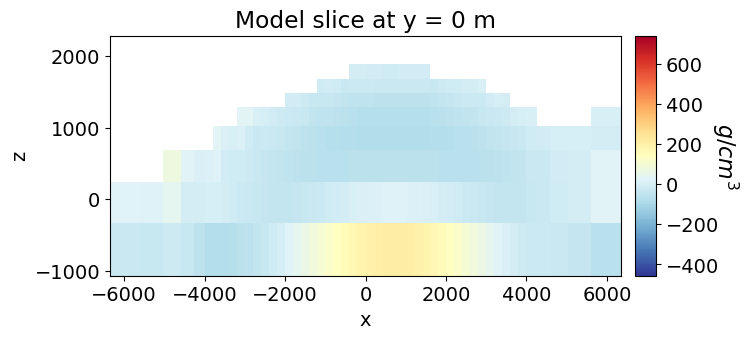

In [43]:
# Plot Recovered Model
fig = plt.figure(figsize=(7, 3))
ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])

norm = mpl.colors.Normalize(
    vmin=np.min(recovered_tensor_model), vmax=np.max(recovered_tensor_model)
)
tensor_mesh.plot_slice(
    tensor_plotting_map * recovered_tensor_model,
    normal="Y",
    ax=ax1,
    ind=int(tensor_mesh.shape_cells[1] / 2),
    grid=False,
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
)
ax1.set_title("Model slice at y = 0 m")

ax2 = fig.add_axes([0.85, 0.1, 0.03, 0.8])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

plt.show()

### Reassign the Uncertainties

In [44]:
# Compute normalized data misfits
normalized_data_misfits = (dobs - dpred) / std

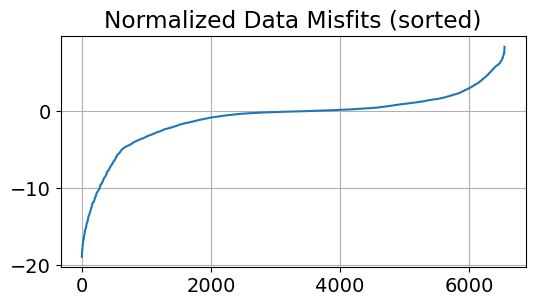

In [45]:
# Plot the normalized data misfits
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)
ax.plot(np.sort(normalized_data_misfits))
ax.set_title("Normalized Data Misfits (sorted)")
ax.grid()
plt.show(fig)